Forward model fitting: from a infectivity curve to model

First we can fit an infectivity curve to two alternative model, the first the simple SEI model with two compartments, and another with more compartments.

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as intg
import scipy.optimize as opt
import numexpr as ne
import numpy.random as rnd
import time

In [45]:
# number of boxes to approximate
nclass = 6
# logit = ll/(1 + exp(-k(x - x0))
k = 0.01
ll = 1
x0 = 130
numOpt = 10

[0.21416502 0.2        0.4        0.6        0.8        1.        ]
[0.21416502 0.38481761 0.5655435  0.74060558 0.89316782 1.        ]
[  0.          45.02786474 120.064056   193.25813341 279.53953248
 417.47476055]


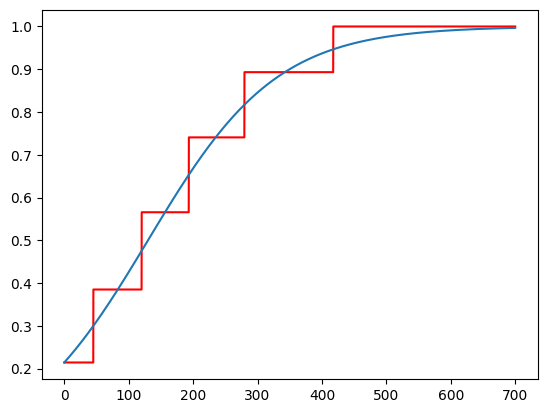

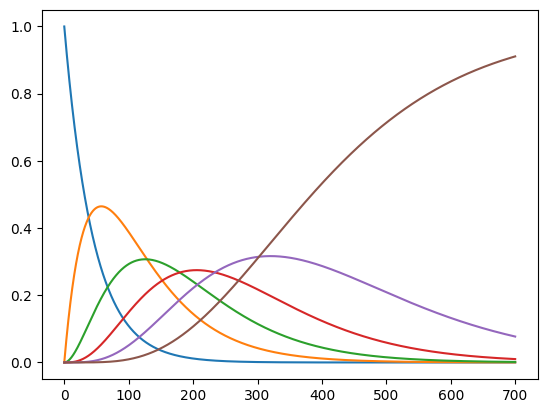

i=0: f=0.00 
i=1: f=0.00 
i=2: f=0.00 
i=3: f=0.00 
i=4: f=0.00 
i=5: f=0.00 
i=7: f=0.00 
i=8: f=7.07 
i=9: f=0.05 
After 10, f=0.00 
[0.20750771843235968, 0.32751498964221004, 0.3275149896422164, 0.7792312230244125, 1.0]
[0.02220847037162981, 0.013326902435355139, 0.013662307598105472, 0.011589983597696902, 0.007249779581304582]
[ 45.02786474  75.03619126  73.19407741  86.28139907 137.93522807]
0.002029491559304196


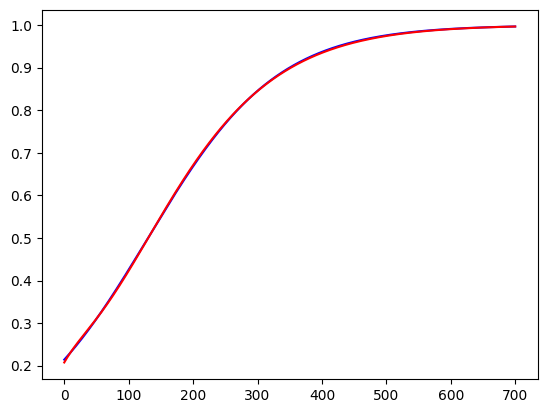

0.9534303843747527
[0.20750772 0.32751499 0.32751499 0.77923122 1.         1.        ]


In [46]:
def logit(x, X0=x0, K=k, L=ll):
    return L/(1+np.exp(-K*(x-X0)))


def inverselogit(y, X0 = x0, K = k, L = ll):
    a = -1/K
    b = L/y - 1
    b = np.log(b)
    return a*b+X0


def approx(x, ts, ys):
    if x > ts[-1]:
        return ys[-1]
    elif x < 0:
        return 0
    else:
        which = np.argmax(ts > x)
        return ys[which-1]


def lost(x, args):
    ts = args[0:nclass]
    ys = args[nclass:2*nclass]
    return np.abs(approx(x, ts, ys) - logit(x))


def delta(nts, nys, ts, ys):
    a = np.append(nts, nys)
    b = np.append(ts, ys)
    return intg.quad(lost, 0, 1000, a) - intg.quad(lost, 0, 1000, b)


yvalues = np.array(range(nclass))/(nclass-1) * ll
yvalues2 = np.array(range(nclass))/(nclass-1) * ll
yvalues[0] = logit(0)
tvalues = np.zeros(nclass)
a = 0
print(yvalues)
while a < 1000:

    for i in range(1, nclass):
        tvalues[i] = inverselogit((yvalues[i-1]+yvalues[i])/2)
    for i in range(1, nclass-1):
        yvalues[i], err = intg.quad(logit, tvalues[i], tvalues[i+1]) / (tvalues[i+1]-tvalues[i])
    a += 1
    # if delta(newtvalues,newyvalues,tvalues,yvalues) < 0:
    #    tvalues = np.array(newtvalues)
    #    yvalues = np.array(newyvalues)
    # else:
    #     opt = False
print(yvalues)
print(tvalues)




times = np.array(range(7000))/10
app = []
logi = []
app2 = []
for t in times:
    app.append(approx(t, tvalues, yvalues))
    logi.append(logit(t))

plt.plot(times, app, color='r')
plt.plot(times, logi)
# plt.plot(times, app2, color="r")
#plt.savefig('step approx 2.png')
plt.show()



def link1(x):
    if x > 0:
        return x+1
    else:
        return np.exp(x)


def inverselink1(x):
    if x > 1:
        return x-1
    else:
        return np.log(x)


def coeff(i, n, rates):
    if i == 1 and n == 1:
        return 1
    elif i < n:
        a = rates[n-2]/(rates[n-1] - rates[i-1])
        return a*coeff(i, n-1, rates)
    elif i == n:
        a = 0
        for k in range(1, n):
            a += coeff(k, n-1, rates)/(rates[n-1]-rates[k-1])
        a *= -rates[n-2]
        return a


def link(s):
    q = []
    for i in range(len(s)):
        q.append(link1(s[i]))
    q = np.cumsum(q)
    b = []
    for i in range(len(s)):
        b.append(logit(inverselink1(q[i]), 0, 1))
    return b


def I(rates, n, t):
    if n < (len(rates)+1):
        a = 0
        for i in range(n):
            a += coeff(i+1, n, rates)*np.exp(-rates[i]*t)
        return a
    elif n == (len(rates)+1):
        a = 1
        for i in range(n):
            a -= I(rates, i, t)
        return a


def theta(beta, rates, t):
    a = 0
    for i in range(len(rates)+1):
        a += beta[i]*I(rates, i+1, t)
    return a

rate = []
for i in range(nclass-1):
    rate.append(1/(tvalues[i+1]-tvalues[i]))


plot = np.zeros([nclass, len(times)])

for t in range(len(times)):
    for n in range(nclass):
        plot[n, t] = I(rate, n + 1, times[t])
for n in range(nclass):
    plt.plot(times, plot[n, :])
#plt.savefig('state in 2boxes.png')
plt.show()


def lostt(t, beta, rate = rate):
    a = theta(beta, rate, t) - logit(t)
    return a**2


def deltaa(beta):
    ii, error = intg.quad(lostt, 0, 1441, beta)
    # print(ii)
    return ii


def foropt(beta):
    beta = link(beta)
    beta.append(1)
    return deltaa(beta)



foundOpt = False

for i in range(numOpt):
    vstart = np.random.standard_cauchy(nclass - 1)
    w = opt.minimize(fun=foropt, x0=vstart)
    if w.success:
        # Report to screen
        print(f"i={i}: f={w.fun:.2f} ")
        # store if is best optimum so far (and flag that one been found)
        if foundOpt:
            if w.fun < bestF:
                bestF = w.fun
                bestX = w.x
                if bestF < 0.00001:
                    break
        else:
            bestF = w.fun
            bestX = w.x
            foundOpt = True
if foundOpt:
    print(f"After {numOpt}, f={bestF:.2f} ")
else:
    print(f"Didn't converge in {numOpt} attempts")

print(link(bestX))
print(rate)
print(1/np.array(rate))
times = np.arange(0, 700, 0.1)
the = []
lo = []
loo = []
thet = []
betas = link(bestX)
betas.append(1)
for t in times:
    lo.append(logit(t, 160, 0.0125, 1))
    loo.append(logit(t))
    the.append(theta(betas, rate, t))
    thet.append(theta(yvalues, rate, t))


plt.plot(times, loo, color = 'b')
plt.plot(times, the, color='r')
# plt.plot(times, thet, color="g")
print(bestF)
#plt.savefig('fitted approx 2.png')
plt.show()
print(deltaa(yvalues))
#np.savetxt("variable width rates.csv", rate)
#np.savetxt("variable width betas.csv", betas)
rates = np.array(rate)
scale = np.array(betas)
print(scale)

Then fit a simple box model, given only one parameter is used, the step function heuristic is not needed

i=0: f=1.29 
i=1: f=1.29 
i=2: f=1.29 
i=3: f=1.29 
i=4: f=1.29 
i=5: f=1.29 
i=6: f=1.29 
i=7: f=1.29 
i=8: f=1.29 
i=9: f=1.29 
After 10, f=1.29 
[0.00606683]
164.8308467378931


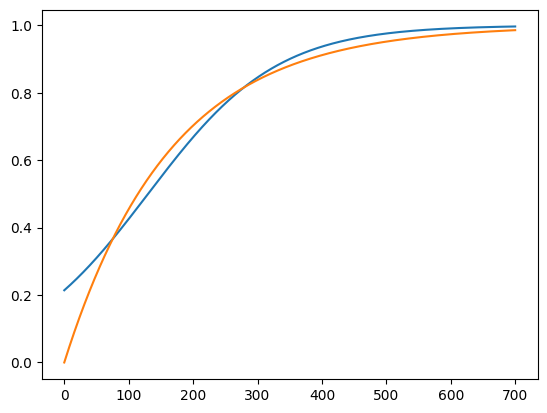

In [47]:
def two_box_approx(x, sigma):
    return 1 - np.exp(-sigma*x)


def squared_deviation(x, sigma):
    return (logit(x) - two_box_approx(x, sigma))**2


def integrated_deviation(x):
    #limit searching with logit to values between 0 and 1
    sigma = logit(x)
    a, b = intg.quad(squared_deviation, 0, 1441, sigma)
    return a


foundOpt = False

for i in range(numOpt):
    vstart = np.random.standard_cauchy(1)
    w = opt.minimize(fun=integrated_deviation, x0=vstart)
    if w.success:
        # Report to screen
        print(f"i={i}: f={w.fun:.2f} ")
        # store if is best optimum so far (and flag that one been found)
        if foundOpt:
            if w.fun < bestF:
                bestF = w.fun
                bestX = w.x
                if bestF < 0.00001:
                    break
        else:
            bestF = w.fun
            bestX = w.x
            foundOpt = True
if foundOpt:
    print(f"After {numOpt}, f={bestF:.2f} ")
else:
    print(f"Didn't converge in {numOpt} attempts")


plt.plot(times, loo)
monomolecular = []
print(logit(bestX))
sigma = logit(bestX[0])
print(1/sigma)
for t in times:
    monomolecular.append(two_box_approx(t, sigma))
plt.plot(times, monomolecular)

now we can compare the predictions between the two models.

In [48]:
beta = 5.25
alpha = 37
tend = 1441
survey_interval = 90

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


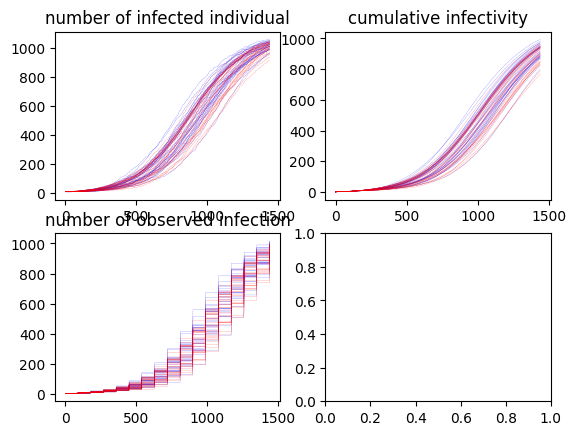

In [49]:
b = scale * beta
b = np.append(np.array([0]), b)
sigma = np.append(rates, np.array([0]))
sigma = np.append(np.array([0]), sigma)

a = alpha
num_tree = 1111
tre = np.loadtxt("smallLandscape.txt")

# dispersal kernel
def dispersal(alpha):
    dis = ne.evaluate("1/(1+(distance/alpha)**2)")
    factor = (np.sum(dis) - 1111) / 2
    dis = ne.evaluate('dis/factor')
    return dis


# pairwise distance matrix
distance = np.zeros([num_tree, num_tree])
for i in range(num_tree):
    for j in range(num_tree):
        distance[i, j] = ((tre[i, 0] - tre[j, 0]) ** 2 + (tre[i, 1] - tre[j, 1]) ** 2) ** 0.5

dispersing = dispersal(a)
dispersing[dispersing < 1e-10] = 0
fig, axs = plt.subplots(2,2)
axs[0,0].set_title("number of infected individual")
axs[0, 1].set_title("cumulative infectivity")
axs[1, 0].set_title("number of observed infection")
# LOOP START
# The model structure is similar to the other models in "different cull radius". the detection scheme is that of gradual change in probability
# here q decides the number of replicates.
for q in range(30):
    print(q)
    ts = [0]
    Ss = [1101]
    Is = [10]
    Infs = [0]
    Obs = [0]
    t = 0
    tree = np.c_[tre, np.zeros(num_tree), np.zeros(num_tree), np.zeros(num_tree), np.zeros(num_tree)]
    initial = rnd.randint(0, num_tree, 10)
    tree[initial, 2] = 1
    tree[initial, 3] = sigma[1]
    # setting initial pressure
    for i in initial:
        for j in np.where(tree[:, 2] == 0)[0]:
            tree[j, 3] += b[1] * dispersing[i, j]
    # loops
    while t < tend:
        # infection
        event = np.cumsum(tree[:, 3])
        time_to_survey = survey_interval - (t % survey_interval)
        rate = event[-1]
        if rate > 0:
            timestep = rnd.exponential(1 / rate)
        else:
            break
        if timestep > time_to_survey:
            p_detected = np.zeros(1111)
            can_detect = np.logical_and(tree[:, 2] > 0, tree[:, 5] == 0)
            p_detected[can_detect] = logit(t + time_to_survey - tree[can_detect, 4])
            survey = np.random.uniform(0, 1, 1111)
            detected = p_detected > survey
            tree[detected, 5] = t + time_to_survey
        t += timestep
        ts.append(t)
        whichevent = rate * rnd.rand()
        which = np.argmax(event > whichevent)
        tree[which, 2] += 1
        state = int(tree[which, 2])
        if state == 1:
            tree[which, 4] = t
        tree[which, 3] = sigma[state]
        db = b[state] - b[state - 1]
        for i in np.where(tree[:, 2] == 0)[0]:
            tree[i, 3] += db * dispersing[which, i]
        Ss.append(sum(tree[:, 2] == 0))
        Is.append(sum(tree[:, 2] > 0))
        Obs.append(sum(tree[:, 5] > 0))
        Infs.append(sum(logit(t - tree[tree[:,2] > 0, 4])))
    #    plt.scatter(tree[tree[:,2]==0,0],tree[tree[:,2]==0,1])
    #    plt.scatter(tree[tree[:,2]==1,0],tree[tree[:,2]==1,1])
    #    plt.scatter(tree[tree[:,2]==2,0],tree[tree[:,2]==2,1])
    #    plt.scatter(tree[tree[:,2]==3,0],tree[tree[:,2]==3,1])
    #    plt.title(t)
    #    plt.show()
    axs[0,0].plot(ts, Is, lw = 0.1, color = "b")
    axs[0, 1].plot(ts, Infs, lw = 0.1, color = "b")
    axs[1, 0].plot(ts, Obs, lw = 0.1, color = "b")



b = [0, 0, beta]
sigma = [0, logit(bestX[0]), 0]
for q in range(30):
    print(q)
    ts = [0]
    Ss = [1101]
    Is = [10]
    Infs = [0]
    Obs = [0]
    t = 0
    tree = np.c_[tre, np.zeros(num_tree), np.zeros(num_tree), np.zeros(num_tree), np.zeros(num_tree)]
    initial = rnd.randint(0, num_tree, 10)
    tree[initial, 2] = 1
    tree[initial, 3] = sigma[1]
    # setting initial pressure
    for i in initial:
        for j in np.where(tree[:, 2] == 0)[0]:
            tree[j, 3] += b[1] * dispersing[i, j]
    # loops
    while t < tend:
        # infection
        event = np.cumsum(tree[:, 3])
        time_to_survey = survey_interval - (t % survey_interval)
        rate = event[-1]
        if rate > 0:
            timestep = rnd.exponential(1 / rate)
        else:
            break
        if timestep > time_to_survey:
            p_detected = np.zeros(1111)
            can_detect = np.logical_and(tree[:, 2] > 0, tree[:, 5] == 0)
            p_detected[can_detect] = logit(t + time_to_survey - tree[can_detect, 4])
            survey = np.random.uniform(0, 1, 1111)
            detected = p_detected > survey
            tree[detected, 5] = t + time_to_survey
        t += timestep
        ts.append(t)
        whichevent = rate * rnd.rand()
        which = np.argmax(event > whichevent)
        tree[which, 2] += 1
        state = int(tree[which, 2])
        if state == 1:
            tree[which, 4] = t
        tree[which, 3] = sigma[state]
        db = b[state] - b[state - 1]
        for i in np.where(tree[:, 2] == 0)[0]:
            tree[i, 3] += db * dispersing[which, i]
        Ss.append(sum(tree[:, 2] == 0))
        Is.append(sum(tree[:, 2] > 0))
        Obs.append(sum(tree[:, 5] > 0))
        Infs.append(sum(logit(t - tree[tree[:,2] > 0, 4])))
    #    plt.scatter(tree[tree[:,2]==0,0],tree[tree[:,2]==0,1])
    #    plt.scatter(tree[tree[:,2]==1,0],tree[tree[:,2]==1,1])
    #    plt.scatter(tree[tree[:,2]==2,0],tree[tree[:,2]==2,1])
    #    plt.scatter(tree[tree[:,2]==3,0],tree[tree[:,2]==3,1])
    #    plt.title(t)
    #    plt.show()
    axs[0,0].plot(ts, Is, lw = 0.1, color = "r")
    axs[0, 1].plot(ts, Infs, lw = 0.1, color = "r")
    axs[1, 0].plot(ts, Obs, lw = 0.1, color = "r")


